## Task 2 - Analysis

Importing necessary libraries to work with

In [47]:
#importing the necessary libraries 
import pandas as pd
import re
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package punkt to /Users/gitahi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gitahi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gitahi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/gitahi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [48]:
#loading the dataset
df = pd.read_csv('/Users/gitahi/fiona/British-airways/data/BA_reviews.csv', index_col=0)
df.head()

,reviews,recommendations
0,✅ Trip Verified | London Heathrow to Mumbai in...,yes
1,"✅ Trip Verified | Keflavík, Iceland to London ...",yes
2,✅ Trip Verified | Terrible Experience with Bri...,no
3,✅ Trip Verified | An airline that lives in the...,no
4,✅ Trip Verified | Check-in Desk rude and dism...,no


In [49]:
df.reviews.value_counts()


British Airways from Tampa to Gatwick on Boeing 777 Club World. Having travelled out WT Plus to Miami we got a good deal coming back from Tampa so flew Club Class. Checked in at Tampa with no queues, and used the International Lounge at Tampa. Supposed to be exclusive to BA customers this had comfortable seats, and good choice of newspapers and magazines. Did not try WiFi. However, there was disappointingly very poor choice of snacks - a few dried up sorry looking sandwiches which were not replenished during my time there, and crackers with some processed cheese with a few dips, some wine, beer, liquor and soft drinks. Pretty uninspiring stuff. On board comfortable, if narrow, seats that extended into (more or less) flat beds. British Airways still have the very camped 2-4-2 layout with fellow passengers having to clamber over people to go to the rest room etc. Reasonable meal (beef) accompanied by an outstanding Chablis Premier Cru and a very nice Sauvignon Blanc. My wife slept for 5 

# Data Cleaning

Identifying and correcting errors, inconsistencies, and inaccuracies in the datasets to improve quality and reliability. 

In [50]:
df['reviews'] [0]

'✅ Trip Verified | London Heathrow to Mumbai in a Boeing 787-8 in Business Class. The lounge near Terminal 5, Gate B36 at Heathrow was outstanding in its service and offerings. It provides us just the right frame to relax in before boarding as the departure was delayed by almost 2 hours. The 787-8 on our flight featured the older Club World seating. Not the best in class but comfortable enough. I hear that the new Club Suites configuration is far superior. British Airways onboard service was outstanding in every respect. All in all, a very comfortable flight. One minor irritant: for some reason this aircraft was not fitted with WiFi. We got into Mumbai at 8 am, a civilized time to arrive.'

Splited the 'reviews' column of the DataFrame df on the character '|' and extracted the second item after splitting. Then, assigned the extracted item back to the 'reviews' column, effectively replacing the original content.



In [51]:
df.reviews= df.reviews.str.split('|',expand=True)[1]
df.head()
     

,reviews,recommendations
0,London Heathrow to Mumbai in a Boeing 787-8 i...,yes
1,"Keflavík, Iceland to London Heathrow on an A3...",yes
2,Terrible Experience with British Airways. I b...,no
3,An airline that lives in their past glory and...,no
4,Check-in Desk rude and dismissive. Flight la...,no


In [52]:
# Function to check for missing values
def check_missing_values(data):
    missing_values = df.isnull().sum()
    if missing_values.any():
        print("Missing values found:")
        print(missing_values)
    else:
        print("No missing values found.")
# Check for missing values
check_missing_values(df)

Missing values found:
reviews            910
recommendations      0
dtype: int64


In [53]:
# Drop row with missing value
df.dropna(axis=0, inplace=True)
# Confirm missing rows dropped
check_missing_values(df)

No missing values found.


The preprocess_text function takes a DataFrame with a 'reviews' column containing text data and performs several text preprocessing steps, including converting to lowercase, removing punctuation, tokenizing, removing stopwords, and lemmatization. The function then returns the DataFrame with the preprocessed 'reviews' column. The resulting preprocessed DataFrame is stored in preprocessed_df.

In [54]:
def preprocess_text(df):
    
    # Convert text to lowercase
    df['reviews'] = df['reviews'].str.lower()
    # Remove punctuations
    df['reviews'] = df['reviews'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    # Tokenize the 'reviews' column
    df['reviews'] = df['reviews'].apply(word_tokenize)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    df['reviews'] = df['reviews'].apply(lambda x: [word for word in x if word not in stop_words])
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    df['reviews'] = df['reviews'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    return df
preprocessed_df = preprocess_text(df)
preprocessed_df

,reviews,recommendations
0,"[london, heathrow, mumbai, boeing, 7878, busin...",yes
1,"[keflavík, iceland, london, heathrow, a320, bu...",yes
2,"[terrible, experience, british, airway, booked...",no
3,"[airline, life, past, glory, heading, future, ...",no
4,"[checkin, desk, rude, dismissive, flight, late...",no
...,...,...
2258,"[istanbul, london, heathrow, british, airway, ...",no
2259,"[london, heathrow, houston, british, airway, f...",yes
2260,"[flown, british, airway, 100, time, usually, b...",no
2261,"[british, airway, seattle, johannesburg, via, ...",yes


After executing this code, the 'recommendations' column in preprocessed_df will contain binary values (1 for 'yes' and 0 for other values), making it suitable for binary classification tasks or further analysis.

In [55]:
preprocessed_df['recommendations'] = preprocessed_df['recommendations'].apply(lambda x: 1 if x=='yes' else 0)
preprocessed_df

,reviews,recommendations
0,"[london, heathrow, mumbai, boeing, 7878, busin...",1
1,"[keflavík, iceland, london, heathrow, a320, bu...",1
2,"[terrible, experience, british, airway, booked...",0
3,"[airline, life, past, glory, heading, future, ...",0
4,"[checkin, desk, rude, dismissive, flight, late...",0
...,...,...
2258,"[istanbul, london, heathrow, british, airway, ...",0
2259,"[london, heathrow, houston, british, airway, f...",1
2260,"[flown, british, airway, 100, time, usually, b...",0
2261,"[british, airway, seattle, johannesburg, via, ...",1


# Modelling

Text stores the textual data (reviews) from the DataFrame, while label stores the corresponding labels or recommendations associated with each review.

In [56]:
text = df['reviews']
label = df['recommendations']

This function is used to split datasets into training and testing subsets.

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text,label,test_size=0.15)


Performed sentiment analysis using a bag-of-words representation and a logistic regression classifier.

In [62]:
# Create a bag-of-words representation of the text data
vectorizer = CountVectorizer(analyzer=lambda x: x)
X_train_bow = vectorizer.fit_transform(X_train).toarray()
X_test_bow = vectorizer.transform(X_test).toarray()
# Train a Logistic Regression classifier for sentiment analysis
clf = LogisticRegression(random_state=42)
clf.fit(X_train_bow, y_train)
# Make predictions on the test set
predictions = clf.predict(X_test_bow)
# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.8630573248407644
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       212
           1       0.84      0.72      0.77       102

    accuracy                           0.86       314
   macro avg       0.86      0.82      0.84       314
weighted avg       0.86      0.86      0.86       314



Decision tree 


In [59]:
# Train a Decision Tree classifier for sentiment analysis
dec_clf = DecisionTreeClassifier(random_state=42)
dec_clf.fit(X_train_bow, y_train)
# Make predictions on the test set
predictions = dec_clf.predict(X_test_bow)
# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.7547770700636943
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       212
           1       0.61      0.66      0.64       102

    accuracy                           0.75       314
   macro avg       0.72      0.73      0.73       314
weighted avg       0.76      0.75      0.76       314



Random Forest

In [63]:
# Train a Random Forest classifier for sentiment analysis
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_bow, y_train)
# Make predictions on the test set
predictions = rf_clf.predict(X_test_bow)
# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.8630573248407644
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       212
           1       0.93      0.63      0.75       102

    accuracy                           0.86       314
   macro avg       0.89      0.80      0.83       314
weighted avg       0.87      0.86      0.85       314



Defining the hyperparameter

In [65]:
# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],      # Number of trees in the forest
    'max_depth': [None, 10, 20],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
}
# Perform grid search using 3-fold cross-validation
grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_bow, y_train)
# Get the best model from grid search
best_rf_clf = grid_search.best_estimator_
# Make predictions on the test set using the best model
predictions = best_rf_clf.predict(X_test_bow)
# Evaluate the best model's performance
print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:")
print(classification_report(y_test, predictions))


Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.856687898089172
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       212
           1       0.94      0.60      0.73       102

    accuracy                           0.86       314
   macro avg       0.89      0.79      0.82       314
weighted avg       0.87      0.86      0.85       314



 Generated a word cloud visualization from the preprocessed text data in the DataFrame preprocessed_df.

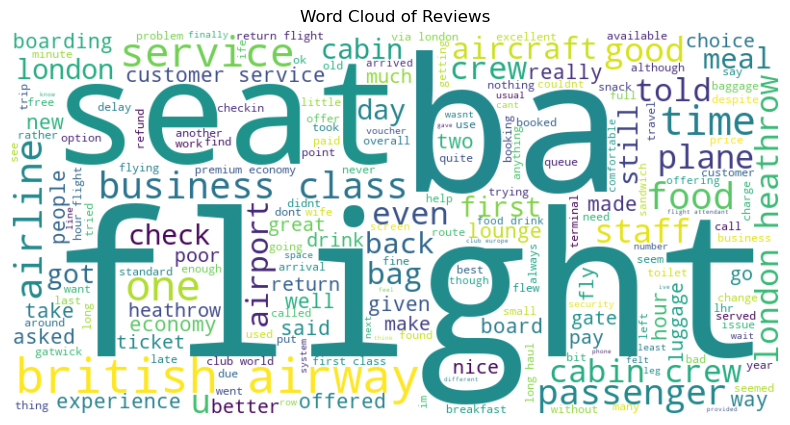

In [66]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Combine all the preprocessed reviews into a single text string
all_reviews_text = ' '.join([' '.join(review) for review in preprocessed_df['reviews']])
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_text)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

Using word frequency analysis to determine the frequency of each word in the preprocessed DataFrame's "reviews" column. and showing the most common terms in a bar chart with their corresponding frequencies.

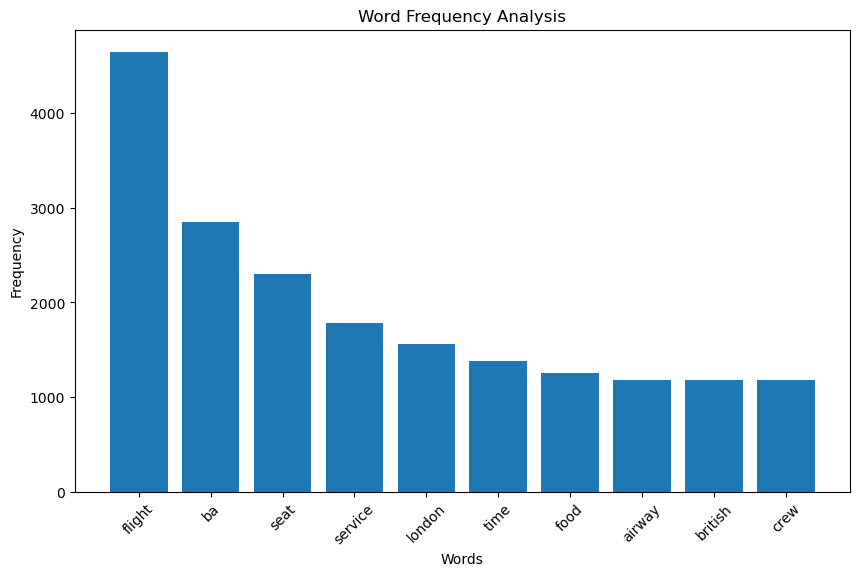

In [68]:
from nltk.probability import FreqDist

# Combine all the preprocessed reviews into a single list of words
all_reviews_words = [word for review in preprocessed_df['reviews'] for word in review]
# Calculate word frequencies
word_freq = FreqDist(all_reviews_words)
# Get the most common words and their frequencies
most_common_words = word_freq.most_common(10)
# Convert to a DataFrame for plotting
word_freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
# Plot the word frequency analysis
plt.figure(figsize=(10, 6))
plt.bar(word_freq_df['Word'], word_freq_df['Frequency'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Analysis')
plt.xticks(rotation=45)
plt.show()

# Topic Modelling

In [69]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

Topic 0: 0.036*"flight" + 0.012*"ba" + 0.012*"time" + 0.009*"hour" + 0.009*"staff" + 0.008*"london" + 0.008*"u" + 0.008*"airway" + 0.008*"british" + 0.007*"told"
Topic 1: 0.020*"flight" + 0.018*"seat" + 0.012*"ba" + 0.010*"airway" + 0.010*"british" + 0.010*"food" + 0.010*"service" + 0.009*"london" + 0.008*"economy" + 0.008*"good"
Topic 2: 0.024*"flight" + 0.018*"ba" + 0.012*"seat" + 0.010*"airline" + 0.008*"british" + 0.008*"airway" + 0.008*"customer" + 0.008*"u" + 0.008*"service" + 0.007*"class"
Coherence Score: 0.3276693139611176


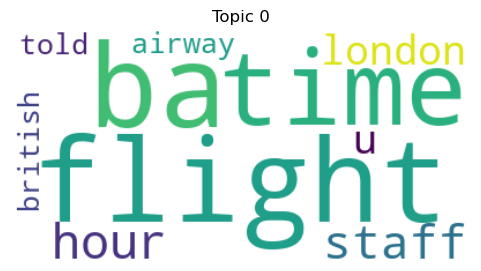

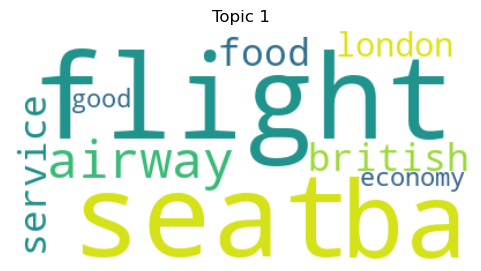

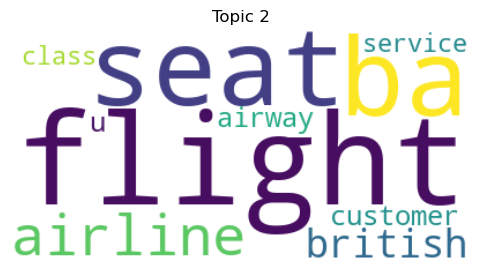

In [70]:
# Create a dictionary and corpus (bag-of-words representation) for LDA
dictionary = corpora.Dictionary(preprocessed_df['reviews'])
corpus = [dictionary.doc2bow(review) for review in preprocessed_df['reviews']]
# Build LDA model
num_topics = 3  # You can change the number of topics as per your requirement
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
# Get topics and their top keywords
topics = lda_model.print_topics(num_topics=num_topics)
# Display topics and top keywords
for topic in topics:
    print(f"Topic {topic[0]}: {topic[1]}")
# Compute coherence score for the model (optional)
coherence_model = CoherenceModel(model=lda_model, texts=preprocessed_df['reviews'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")
# Visualize topics using word clouds (optional)
for topic in topics:
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(topic[1])
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic[0]}")
    plt.show()